## Obtaining Twitter data

In [1]:
# Load libraries
import pandas as pd
import time
import json

# Load Twitter API client
from searchtweets import ResultStream, gen_rule_payload, load_credentials, collect_results

### Define API arguments

In [2]:
# Define arguments to be able to connect to Twitter API for the last 30 days of tweets
premium_30day_search_args = load_credentials(filename=".twitter_keys.yaml",
                 yaml_key="search_30day_tweets_api",
                 env_overwrite=False)

# Define arguments to be able to connect to Twitter API for the last 30 days of tweets
premium_fullarchive_search_args = load_credentials(filename=".twitter_keys.yaml",
                 yaml_key="search_fullarchive_tweets_api",
                 env_overwrite=False)


cannot read file .twitter_keys.yaml
Error parsing YAML file; searching for valid environment variables
Account type is not specified and cannot be inferred.
        Please check your credential file, arguments, or environment variables
        for issues. The account type must be 'premium' or 'enterprise'.
        


KeyError: 

### Extract last 30 days data

In [3]:
# Extract last 30 days tweets using Twitter API
# This is due to tweets older than 30 days use a different end point and limit quota

write_to_disk = False
if write_to_disk:
    all_tweets = []
    for t in list(range(1,30)):
        from_date = str(t).zfill(2)
        to_date = str(t+1).zfill(2)

        rule = gen_rule_payload(
            "UK coronavirus lang:en",
            from_date=f"2020-05-{from_date}", 
            to_date=f"2020-05-{to_date}",
            results_per_call=100
        )

        tweets = collect_results(rule, max_results=500, result_stream_args=premium_30day_search_args) 

        all_tweets.extend(tweets)
        print(len(all_tweets))
        # Set a sleep time to avoid hitting API limits
        time.sleep(10)

        # Write extacted tweets to a JSON file
        with open('data.json', 'w', encoding='utf-8') as f:
            json.dump(all_tweets, f, indent=4, ensure_ascii=False)
        
        

### Extract data older than 30 days

In [4]:
# Extract tweets older than 30 days
# This is due to tweets older than 30 days use a different end point and limit quota

# Extract tweets older then 30 days using Twitter API
write_to_disk = False
if write_to_disk:
    month = '04' # specify month number
#     all_tweets = []
    for t in list(range(1,30)):
        from_date = str(t).zfill(2)
        to_date = str(t+1).zfill(2)

        rule = gen_rule_payload(
            "UK coronavirus lang:en",
            from_date=f"2020-{month}-{from_date}", 
            to_date=f"2020-{month}-{to_date}",
            results_per_call=100
        )

        tweets = collect_results(rule, max_results=150, result_stream_args=premium_fullarchive_search_args) 

        all_tweets.extend(tweets)
        print(f"2020-{month}-{to_date}")
        print(len(all_tweets))
        print('---')
        # Set a sleep time to avoid hitting API limits
        time.sleep(10)

        # Write extacted tweets to a JSON file
        with open('data.json', 'w', encoding='utf-8') as f:
            json.dump(all_tweets, f, indent=4, ensure_ascii=False)

### Load tweet data

In [5]:
# Read JSON file that contains tweet data
with open('data.json', 'r',) as f:
    tweets = json.load(f)

# Check number of tweets
len(tweets)

FileNotFoundError: [Errno 2] No such file or directory: 'data.json'

In [6]:
# Print twitter text sample
[print(tweet.get('text'),'\n\n') for tweet in tweets[0:3]]

NameError: name 'tweets' is not defined

In [ ]:
# Check all keys associated with individual tweet objects
tweet_keys = []
for t in tweets:
    tweet_keys.extend(list(t.keys()))
    tweet_keys = list(set(tweet_keys))
    
tweet_keys = sorted(tweet_keys)
tweet_keys

In [ ]:
# Check whether all tweets are unique tweets
unique_tweets = []
ids = []
for t in tweets:
    if not t.get('id') in ids:
        ids.append(t.get('id'))
        unique_tweets.append(t)
    else:
        pass

len(unique_tweets)

In [ ]:
# Extract text content from individual tweets
write_text_tweets = True

if write_text_tweets:
    
    text_tweets = []
    for t in unique_tweets:
        t_ = {}
        if t.get('retweeted_status'):
            t_['id'] = t.get('retweeted_status').get('id')
            t_['created_at'] = t.get('retweeted_status').get('created_at')
            if t.get('retweeted_status').get('extended_tweet'):
                t_['text'] = t.get('retweeted_status').get('extended_tweet').get('full_text')
            else:
                t_['text'] = t.get('retweeted_status').get('text')
        else:
            t_['id'] = t.get('id')
            t_['created_at'] = t.get('created_at')
            if t.get('extended_tweet'):
                t_['text'] = t.get('extended_tweet').get('full_text')
            else:
                t_['text'] = t.get('text')

        text_tweets.append(t_)

    print(len(text_tweets))

    df = pd.DataFrame(text_tweets)
    df.to_csv('tweets.csv', encoding='utf-8', index=False)
    print('Tweet text saved to file!')
            

In [ ]:
df.head()

## Scrubbing the text

In [ ]:
def remove_emojis(text):
    import re
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', text)

In [ ]:
# Define text processing function
def preprocess(text):
    import re, string
    
    text = text.replace('(<br/>)', ' ')
    text = text.replace('(&amp)', ' ')
    text = text.replace('(&gt)', ' ')
    text = text.replace('(&lt)', ' ')
    text = text.replace('(\xa0)', ' ')
    text = text.replace(r'\n',' ',)
    text = text.replace('"',' ',)
    text = text.replace("'",' ',)
    
    # Remove URL
    text = re.sub(r"(?:\@|http?\://|https?\://|www.)\S+", "", text)
    
    # Remove emoji
    text = remove_emojis(text)
    
    # Remove punctuation
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    
    # Remove white space
    text = " ".join(text.split())
    
    return text

In [ ]:
df['cleaned_text'] = df['text'].apply(preprocess)


In [ ]:
df.head()\


In [ ]:
# Saving tweet data as csv
df.to_csv('cleaned_tweets.csv', encoding='utf-8', index=False)


## Exploratory Data Analysis  

### VADER Sentiment Analysis and Feature Engineering

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Creating columns for each polarity score
df['negative'] = df['cleaned_text'].apply(lambda cleaned_text: analyzer.polarity_scores(cleaned_text)['neg'])
df['neutral'] = df['cleaned_text'].apply(lambda cleaned_text: analyzer.polarity_scores(cleaned_text)['neu'])
df['positive'] = df['cleaned_text'].apply(lambda cleaned_text: analyzer.polarity_scores(cleaned_text)['pos'])
df['compound'] = df['cleaned_text'].apply(lambda cleaned_text: analyzer.polarity_scores(cleaned_text)['compound'])


In [ ]:
df.info()

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

positive sentiment: compound score >= 0.05

neutral sentiment: (compound score > -0.05) and (compound score < 0.05)

negative sentiment: compound score <= -0.05

In [ ]:
df['vader_score'] = df['compound'].apply(lambda x: -1 if x<= -0.06 else(1 if x>= 0.06 else 0))

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
df['vader_score'].value_counts(normalize=True).plot.bar()
ax.set_ylabel('Percentage')
ax.set_xlabel('Labels')
ax.set_title('Distribution of Sentiment')
plt.show()

### Visualizing  Time Series

In [ ]:
# Converting the columns type to datetime
df['date'] = pd.to_datetime(df['created_at'], errors='coerce')
df.head()


In [ ]:
# Defining a new dataframe and setting date as index
df_a = df[['date', 'negative', 'neutral', 'positive', 'compound']].set_index('date')
df_a.head()


In [ ]:
# Limiting index with the related tweet data
df_ = df_a['2020-03-15':'2020-05-30']
df_.index.min()


In [ ]:
# Calculating daily average for each column
av_daily = df_.resample('D').mean()
av_daily.head(10)


In [ ]:
# Visualizing polarity scores
import matplotlib.pyplot as plt
%matplotlib inline

av_daily.plot(figsize = (18,10), subplots=False, legend=True)
plt.show()


In [ ]:
# Plot the yearly groups as subplots
av_daily.plot(figsize = (22,15), subplots=True, legend=True)
plt.show()


### Ngram Exploration


#### Unigrams 

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
np.random.seed(0)


In [ ]:
# 
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [ ]:
# Getting top 50 unigrams
unigrams = get_top_n_words(df['cleaned_text'],50)


In [ ]:
# Visualizing top 50 unigrams
df_uni = pd.DataFrame(unigrams, columns = ['text' , 'count'])

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12,12))
df_uni.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax);
ax.set_xlabel('Count')
ax.set_ylabel('Unigrams')
ax.set_title('Top 50 Unigrams')
plt.show()


In [ ]:
pos = df[df['vader_score']== 1]
neg = df[df['vader_score']== -1]
neutral = df[df['vader_score']== 0]

In [ ]:
pos_unigrams = get_top_n_words(pos['cleaned_text'],20)
neg_unigrams = get_top_n_words(neg['cleaned_text'],20)
neutral_unigrams = get_top_n_words(neutral['cleaned_text'],20)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
df1 = pd.DataFrame(pos_unigrams, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('Unigrams')
ax.set_title('Top 20 Unigrams in positive text')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
df2 = pd.DataFrame(neg_unigrams, columns = ['text' , 'count'])
df2.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('Unigrams')
ax.set_title('Top 20 Unigrams in negative text')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
df3 = pd.DataFrame(neutral_unigrams, columns = ['text' , 'count'])
df3.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('Unigrams')
ax.set_title('Top 20 Unigrams in negative text')
plt.show()

#### Bigrams 

In [ ]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
bigrams = get_top_n_gram(df['cleaned_text'],(2,2),50)

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
df_bigram = pd.DataFrame(bigrams, columns = ['text' , 'count'])
df_bigram.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax);
ax.set_xlabel('Count')
ax.set_ylabel('Bigrams')
ax.set_title('Top 50 Bigrams')
plt.show()

In [ ]:
pos_bigrams = get_top_n_gram(pos['cleaned_text'],(2,2),20)
neg_bigrams = get_top_n_gram(neg['cleaned_text'],(2,2),20)
neutral_bigrams = get_top_n_gram(neutral['cleaned_text'],(2,2),20)


In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
df1 = pd.DataFrame(pos_bigrams, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('Bigrams')
ax.set_title('Top 20 Bigrams in positive text')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
df2 = pd.DataFrame(neg_bigrams, columns = ['text' , 'count'])
df2.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('Bigrams')
ax.set_title('Top 20 Bigrams in negative text')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
df3 = pd.DataFrame(neutral_bigrams, columns = ['text' , 'count'])
df3.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('Bigrams')
ax.set_title('Top 20 Bigrams in negative text')
plt.show()

####  Trigrams

In [ ]:
trigrams = get_top_n_gram(df['cleaned_text'],(3,3),20)

In [ ]:
df_trigrams = pd.DataFrame(trigrams, columns = ['text' , 'count'])

fig, ax = plt.subplots(figsize=(10,10))
df_trigrams.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax);
ax.set_xlabel('Count')
ax.set_ylabel('Trigrams')
ax.set_title('Top 20 Trigrams')
plt.show()

In [ ]:
pos_trigrams = get_top_n_gram(pos['cleaned_text'],(3,3),20)
neg_trigrams = get_top_n_gram(neg['cleaned_text'],(3,3),20)
neutral_trigrams = get_top_n_gram(neutral['cleaned_text'],(3,3),20)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
df1 = pd.DataFrame(pos_trigrams, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Quantity')
ax.set_ylabel('Trigrams')
ax.set_title('Top 20 Trigrams in positive text')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
df2 = pd.DataFrame(neg_trigrams, columns = ['text' , 'count'])
df2.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Quantity')
ax.set_ylabel('Trigrams')
ax.set_title('Top 20 Trigrams in negative text')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
df3 = pd.DataFrame(neutral_trigrams, columns = ['text' , 'count'])
df3.groupby('text').sum()['count'].sort_values(ascending=True).plot.barh(ax=ax)
ax.set_xlabel('Quantity')
ax.set_ylabel('Trigrams')
ax.set_title('Top 20 Trigrams in negative text')
plt.show()

### Text Statistics

#### Text word count analysis

In [ ]:
df['text_len'] = df['cleaned_text'].astype(str).apply(len)
df['text_word_count'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.set_color_codes()
ax = sns.distplot(pos['text_word_count'], color="r", kde=False)
ax.set(title = 'Positive Text Word Count', xlabel = 'Text Count', ylabel = 'Frequency');

plt.figure(figsize=(12,8))
ax = sns.distplot(neg['text_word_count'], color="b", kde=False)
ax.set(title = 'Negative Text Word Count', xlabel = 'Text Count', ylabel = 'Frequency');

plt.figure(figsize=(12,8))
ax = sns.distplot(neutral['text_word_count'], color="g", kde=False)
ax.set(title = 'Neutral Text Word Count', xlabel = 'Text Count', ylabel = 'Frequency');

#### Sentence length analysis

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.set_color_codes()
ax = sns.distplot(pos['text_len'], color="r", kde=False)
ax.set(title = 'Positive Text Length Distribution', xlabel = 'Text Length', ylabel = 'Frequency');

plt.figure(figsize=(12,8))
ax = sns.distplot(neg['text_len'], color="b", kde=False)
ax.set(title = 'Negative Text Length Distribution', xlabel = 'Text Length', ylabel = 'Frequency');

plt.figure(figsize=(12,8))
ax = sns.distplot(neutral['text_len'], color="g", kde=False)
ax.set(title = 'Neutral Text Length Distribution', xlabel = 'Text Length', ylabel = 'Frequency');


In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.violinplot(x="vader_score", y='text_len', palette="Blues", data=df);

### WordClouds 

In [ ]:
positive_text = df[df['vader_score'] == 1]['cleaned_text']
negative_text = df[df['vader_score'] == -1]['cleaned_text']
neutral_text = df[df['vader_score'] == 0]['cleaned_text']

In [ ]:
from wordcloud import WordCloud
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_text))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive text',fontsize=30);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_text))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative text',fontsize=30);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neutral_text))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral text',fontsize=30);

## Modeling 

### Time Series  Analysis

In [148]:
import pandas as pd
df_deaths = pd.read_csv('coronavirus_deaths_latest.csv')
df_cases = pd.read_csv('coronavirus_cases_latest.csv')
display(df_deaths.head(10))
df_cases.head(10)

,Area name,Area code,Area type,Reporting date,Daily change in deaths,Cumulative deaths
0,Wales,W92000004,Nation,2020-06-09,9.0,1410
1,Scotland,S92000003,Nation,2020-06-09,0.0,2415
2,Northern Ireland,N92000002,Nation,2020-06-09,0.0,537
3,United Kingdom,K02000001,UK,2020-06-09,286.0,40883
4,England,E92000001,Nation,2020-06-09,277.0,36521
5,Wales,W92000004,Nation,2020-06-08,3.0,1401
6,Scotland,S92000003,Nation,2020-06-08,0.0,2415
7,Northern Ireland,N92000002,Nation,2020-06-08,0.0,537
8,United Kingdom,K02000001,UK,2020-06-08,55.0,40597
9,England,E92000001,Nation,2020-06-08,52.0,36244


,Area name,Area code,Area type,Specimen date,Daily lab-confirmed cases,Previously reported daily cases,Change in daily cases,Cumulative lab-confirmed cases,Previously reported cumulative cases,Change in cumulative cases,Cumulative lab-confirmed cases rate
0,England,E92000001,Nation,2020-06-08,11.0,0.0,11.0,155651,155000.0,651.0,278.1
1,South West,E12000009,Region,2020-06-08,1.0,NaN,NaN,7852,NaN,NaN,140.2
2,South East,E12000008,Region,2020-06-08,1.0,NaN,NaN,22090,NaN,NaN,241.9
3,London,E12000007,Region,2020-06-08,0.0,NaN,NaN,27194,NaN,NaN,305.3
4,East of England,E12000006,Region,2020-06-08,0.0,NaN,NaN,14712,NaN,NaN,237.2
5,West Midlands,E12000005,Region,2020-06-08,1.0,NaN,NaN,16531,NaN,NaN,280.2
6,East Midlands,E12000004,Region,2020-06-08,2.0,NaN,NaN,9450,NaN,NaN,196.7
7,Yorkshire and The Humber,E12000003,Region,2020-06-08,4.0,NaN,NaN,14714,NaN,NaN,268.5
8,North West,E12000002,Region,2020-06-08,2.0,NaN,NaN,26320,NaN,NaN,360.9
9,North East,E12000001,Region,2020-06-08,0.0,NaN,NaN,10390,NaN,NaN,390.9


In [149]:
df_deaths.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446 entries, 0 to 445
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Area name               446 non-null    object 
 1   Area code               446 non-null    object 
 2   Area type               446 non-null    object 
 3   Reporting date          446 non-null    object 
 4   Daily change in deaths  442 non-null    float64
 5   Cumulative deaths       446 non-null    int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 21.0+ KB


In [150]:
df_deaths['date'] = pd.to_datetime(df_deaths['Reporting date'], errors='coerce')

In [151]:
df_deaths['date'].dtype

dtype('<M8[ns]')

In [154]:
df_deaths.sort_values(by=['date'], inplace=True, ascending=True)

In [155]:
df_deaths.head()

,Area name,Area code,Area type,Reporting date,Daily change in deaths,Cumulative deaths,date
445,England,E92000001,Nation,2020-03-06,NaN,1,2020-03-06
444,United Kingdom,K02000001,UK,2020-03-06,1.0,1,2020-03-06
442,United Kingdom,K02000001,UK,2020-03-07,1.0,2,2020-03-07
443,England,E92000001,Nation,2020-03-07,1.0,2,2020-03-07
440,United Kingdom,K02000001,UK,2020-03-08,0.0,2,2020-03-08


In [156]:
df_d= df_deaths[['date', 'Area name', 'Cumulative deaths']].set_index('date')

In [157]:
df_d= df_d.loc[df_d['Area name']=='United Kingdom']

In [158]:
df_d.drop(['Area name'], axis=1, inplace=True)

In [159]:
df_d.head()

,Cumulative deaths
date,
2020-03-06,1
2020-03-07,2
2020-03-08,2
2020-03-09,3
2020-03-10,7


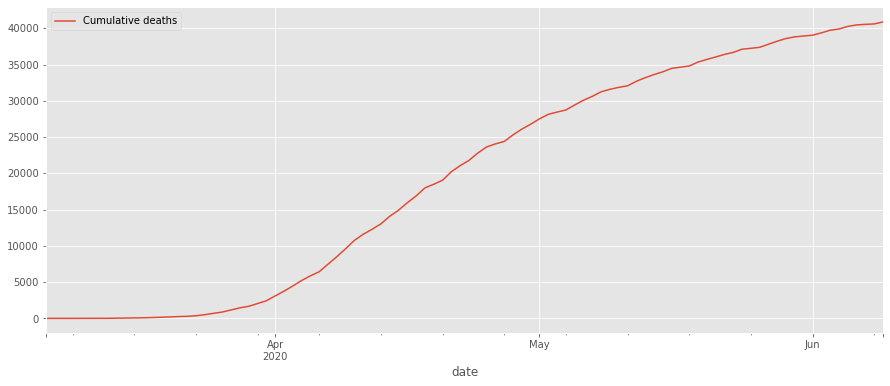

In [160]:
import matplotlib.pyplot as plt
%matplotlib inline
df_d.plot(figsize=(15, 6))
plt.show()

In [161]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [162]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [163]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_d,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2195.134023465834
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =1890.5661327428281
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1697.961888509052
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1384.810223630005
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1675.9014000401849
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1613.4191759133917
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1379.8070793340823
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1344.074119048091
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =2106.5136061090348
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =1827.0011145932053
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =1569.8290586615246
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =1277.8979317564301
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =1565.6339999491272
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =1459.0554627870667
ARIMA (0, 

In [164]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           947.218
Name: 63, dtype: object

In [165]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_d, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9543      0.032     29.395      0.000       0.891       1.018
ma.L1         -0.4861      0.100     -4.875      0.000      -0.682      -0.291
ar.S.L12      -0.2072      0.155     -1.339      0.181      -0.511       0.096
ma.S.L12      -1.0004      0.244     -4.096      0.000      -1.479      -0.522
sigma2      3.618e+04   6.75e-06   5.36e+09      0.000    3.62e+04    3.62e+04


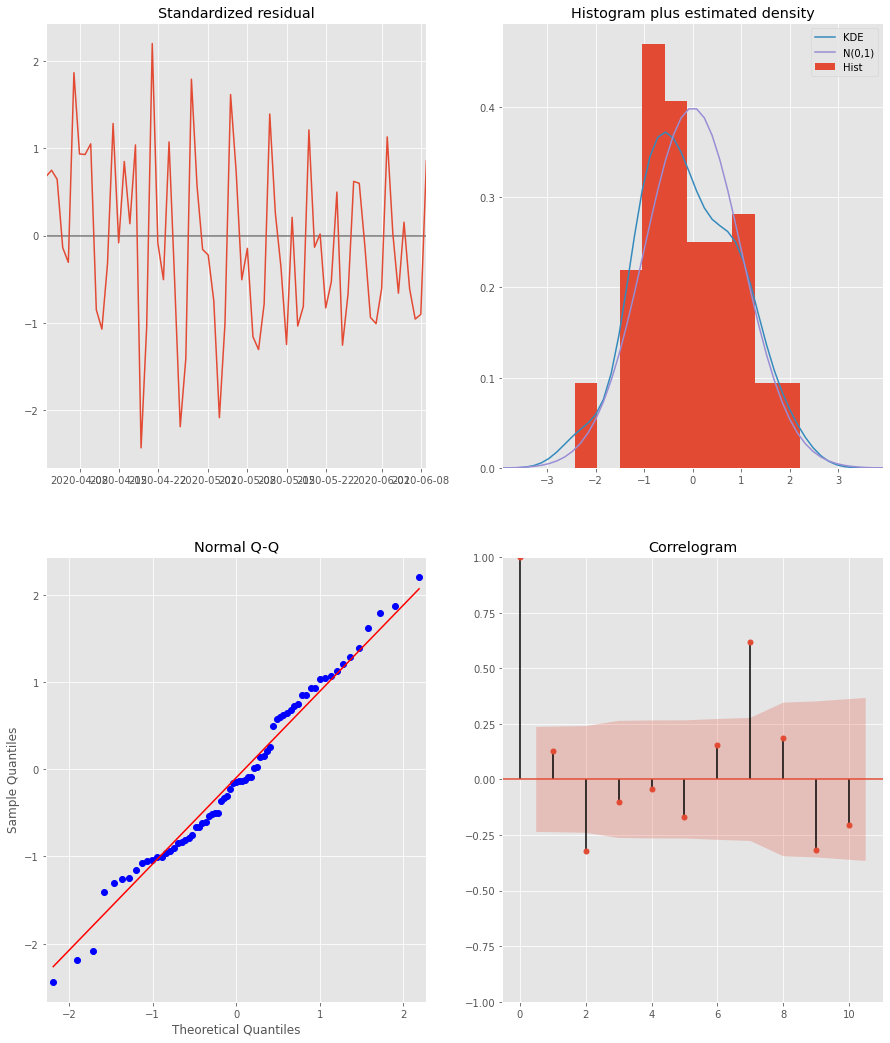

In [166]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [169]:
pred = output.get_prediction(start=pd.to_datetime('2020-05-01'), dynamic=False)
pred_conf = pred.conf_int()

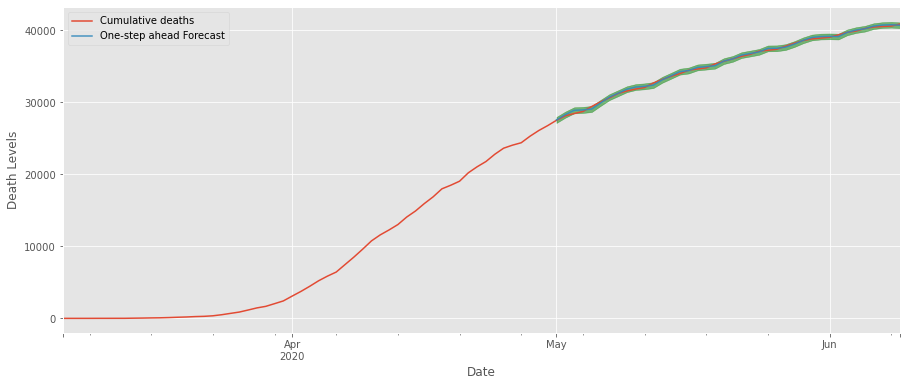

In [170]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = df_d.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Death Levels')
plt.legend()

plt.show()

In [190]:
# Get the real and predicted values
death_forecasted = pred.predicted_mean
death_truth = df_d['2020-05-01':]['Cumulative deaths'].values

# Compute the mean square error
mse = ((death_forecasted - death_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))

The Mean Squared Error is 33958.48


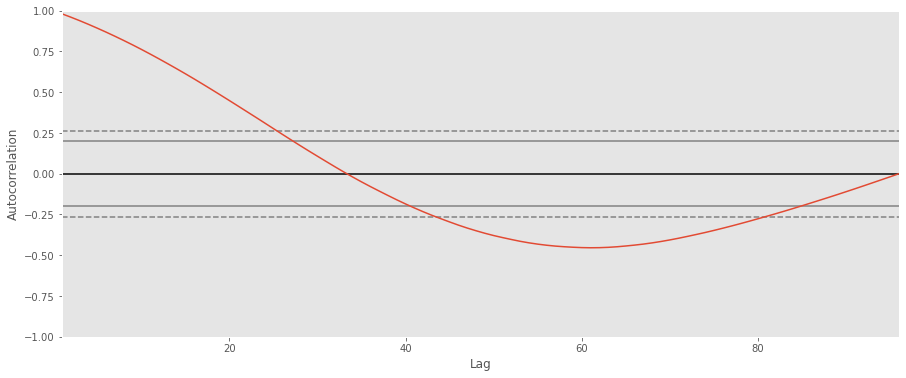

In [193]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_d)
plt.show()